# Lab 06.a: Introduction to Retrieval Augmented Generation (RAG)

所有基礎模型都是在特定時間點的數據快照上進行訓練的。因此，它們只知道訓練語料中包含的事實。例如，如果問基礎模型今天的天氣如何，以及是否帶家人去海灘是個好主意，它可能無法回答你的問題。這種限制源於今天的天氣數據並不包含在其訓練數據中。

<center><img src="imgs/diag_rag_1.png" width="800" alt="Diagram of user interacting with FM"></center><br>

我們可以在 [**watsonx.ai**](https://watsonx.ai) 比較兩個模型, 並測試他的結果
首先, 先試試 `google/flan-ul2` 模型.

<center><img src="imgs/rag_1.png" width="800" alt="Flan-UL2 trying to answer questions about today's weather"></center><br>

接著, 試試透過instruction 微調過的 `ibm/mpt-7b-instruct2` 模型.

<center><img src="imgs/rag_2.png" width="800" alt="MPT-7b-Instruct2 trying to answer questions about today's weather"></center><br>

不幸的是，這些結果都不令人滿意。這是因為這些模型都沒有受過今天的天氣數據的訓練。然而，基礎模型是通過廣泛的數據集進行訓練，涵蓋了各種各樣的主題，使它們在語言學方面熟練，並能夠從最近的事實或訓練期間未包含的信息中學習，比如從您的企業數據中學習。

**檢索增強生成**（或簡稱**RAG**）是一種用於檢索關於特定主題的相關數據並通過您的提示將其作為上下文提供給基礎模型的技術。

以相同的目標為前提，如果我們能將天氣API數據作為上下文傳遞給模型並重新詮釋相同的問題，你認為它能夠生成一個回答嗎？

藉由提供天氣API數據作為上下文，基礎模型可能能夠生成更具相關性的回答，因為它會有關於今天的天氣的信息。然而，模型的能力仍然受限於其訓練數據的範圍，如果沒有涵蓋有關特定天氣情況的足夠信息，回答仍可能不夠準確。這種技術可以改進回答的質量，但取決於可用的數據和模型的能力。
<center><img src="imgs/diag_rag_2.png" width="800" alt="Diagram of user interacting with FM within a context"></center><br>

讓我們實際看看

<center><img src="imgs/rag_3.png" width="800" alt="MPT-7b-Instruct2 working with context"></center><br>

相同的原則適用於文檔。假設你希望你的模型回答有關一段文字的問題，那麼你可以將這段文字作為上下文傳遞，並讓你的模型回答相關的問題。

為了證明這一點，我們可以問一個基礎模型誰是美國的總統。然而，它們中的任何一個都不太可能提供簡潔和可靠的答案。例如，`GPT-3.5` 提供了以下回應：

> *"As of my last knowledge update in September 2021, the President of the United States was Joe Biden. However, please note that my information might be outdated, and I don't have browsing capabilities to access real-time data. If the current date is after September 2021, I recommend checking a reliable news source or performing a quick online search to find the most up-to-date information on the current President of the United States."*

如果我們使用與上述相同的方法並為我們的模型提供一些上下文，這些將是結果。

<center><img src="imgs/rag_4.png" width="800" alt="MPT-7b-Instruct2 working with context"></center><br>

我們可以使用多個不同的數據來源來增強我們的提示，例如文件、數據庫、存儲庫或API。然而，為了使這個過程實用且負擔得起，我們需要進行一些步驟。

現在，我們考慮一種情況，你希望你的模型回答有關一本潛水艇手冊的問題，而這本手冊跨足了492頁。你可能會想知道我們是否可以將這本手冊作為上下文傳遞嗎？

對於基礎模型來說，通常不適合將一本492頁的手冊作為上下文，因為這樣的上下文過於龐大，模型可能難以處理。通常，我們會希望提供更精簡和相對較小範圍的上下文，以確保模型能夠有效地處理並生成相應的答案。這可能包括提取手冊中的特定部分或有關特定主題的摘要，而不是整本手冊。

<center><img src="imgs/diag_rag_3.png" width="800" alt="Diagram of user interacting with FM within a context"></center><br>

這絕對不是最佳的方法。首先，你可能已經注意到的，所有基礎模型都有一個**上下文**，它基本上代表它們可以處理的最大標記數。這個訊息顯示在我們的Prompt Studio頁面底部。傳送整本手冊無疑會超過**任何**基礎模型的最大標記限制。

即使可能傳送整本手冊，模型的API每次使用都是基於使用的標記數來計費的。因此，我們的提示越長，成本就越高。想像一下為每個問題處理這麼多的標記！

這就是**語義查詢**(Semantic Search)發揮作用的地方。

## Semantic Search

想法是將整個文檔，或我們的文件集，轉換為更小的文本片段。有許多不同的方法可以實現這一目標，我們可以在接下來的討論中深入探討。但主要的觀點是我們需要將它分解成較小的文本片段。這樣可以更有效地處理和檢索相關訊息，並使整個過程更實用和負擔得起。

<center><img src="imgs/diag_rag_4.png" width="200" alt="Breaking a documento into chunks"></center><br>

獲得這些較小的文本片段後，我們的目標是接收用戶的問題，並識別哪些文本片段更有可能包含答案。為了確定這種相似性，我們需要將每個文本片段（包括問題本身）轉換成嵌入。

一旦我們將文本片段表示為向量，我們可以測量它們之間的距離。通過這樣做，我們可以識別手冊的哪些部分在語義上更接近我們的問題。因此，我們只傳遞最相關的手冊部分作為上下文，而不是發送全部內容。

如果你對這個過程不完全理解，不用擔心。讓我們一起執行代碼，看看是否能解決你的疑問。

----------

# RAG in Practice

在這個實驗中，我們將開發一個RAG，用於回答有關單個PDF文件的問題，以保持簡單。你可以使用提供的資料夾中的PDF文件，或者使用自己的文件。

## Installing the Libraries

In [ ]:
!pip3 install requests
!pip3 install numpy
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install ibm-watson-machine-learning

!pip3 install langchain
!pip3 install pypdf
!pip3 install chromadb
!pip3 install sentence-transformers

## Importing the Libraries

In [2]:
#import fitz
import os
import re
import requests

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from chromadb.api.types import EmbeddingFunction
from dotenv import load_dotenv

from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

from langchain.document_loaders import PyPDFLoader
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from typing import Literal, Optional, Any

## Pre-download embedding function

In [26]:
%%time
# Load the model from TF Hub (might have connection issue)
class MiniLML6V2EmbeddingFunction(EmbeddingFunction):
    MODEL = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    def __call__(self, texts):
        return MiniLML6V2EmbeddingFunction.MODEL.encode(texts).tolist()
        
emb_function = MiniLML6V2EmbeddingFunction()

ConnectionError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f8e697f78e0>: Failed to establish a new connection: [Errno 60] Operation timed out'))

## PDF to Text

當然，我們的第一步是從PDF文件中提取文字。我們還將對此文本進行預處理，以去除換行和多餘的空格，以保持簡潔和乾淨。

我們定義兩個輔助函數來執行這些操作。

In [4]:
def pdf_to_text(path: str,
                start_page: int = 1,
                end_page: Optional[int or None] = None) -> list[str]:
    """
    Converts PDF to plain text.

    Params:
        path (str): Path to the PDF file.
        start_page (int): Page to start getting text from.
        end_page (int): Last page to get text from.
    """
    loader = PyPDFLoader(path)
    pages = loader.load()
    total_pages = len(pages)

    if end_page is None:
        end_page = len(pages)

    text_list = []
    for i in range(start_page-1, end_page):
        text = pages[i].page_content
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        text_list.append(text)

    return text_list

在定義了我們的函數之後，我們可以開始處理我們的PDF文件。

選擇一個可用的文件，或者使用自己的文件。

然後，我們將在下方印出文件的內容。

In [ ]:
# PDF files available:
#    "pdfs/pie_recipe.pdf"
#    "pdfs/paper_flowers.pdf"

text_list = pdf_to_text("DQ2.pdf")

In [10]:
print(text_list[:2])

[' DQ2 國際贏家 使用手冊 精誠資訊 Submit on 2015 年06月 This document contains information proprietary to S ystex Corporation, and may not be reproduced, disclosed or used in whole or in part without the e xpress written permission of Systex Corporation. © 2014 Systex Corporation ', '目錄 基本篇 .................................................. ................................................... ................................... 6 第一單元 前言 .................................................. ................................................... ...................... 7 1.1 功能架構 .................................................. ................................................... .................. 8 1.2 系統需求 .................................................. ................................................... ................ 16 1.3 安裝指南 .................................................. ................................................... ................ 17 1.4 開始使用 DQ2 ...................................

## Text to Chunks

在提取和處理文本之後，下一步是將其分成均勻分佈的文本片段。

正如先前提到的，有各種不同的方法和技術可供選擇，我們需要找到最適合我們用例的方法。

在這裡，我們將使用一種通用的方法，以頁為單位，將頁定義為一個片段。

另外，我們的函數會記錄每個片段的頁碼。

In [11]:
def text_to_chunks(texts: list[str],
                   start_page: int = 1) -> list[list[str]]:
    """
    Splits the text into equally distributed chunks.

    Args:
        texts (str): List of texts to be converted into chunks.
        word_length (int): Maximum number of words in each chunk.
        start_page (int): Starting page number for the chunks.
    """
    text_toks = [t.split(' ') for t in texts]
    chunks = []

    for idx, words in enumerate(text_toks):

        chunk = ' '.join(words).strip()
        chunk = f'[Page no. {idx+start_page}]' + ' ' + '"' + chunk + '"'
        chunks.append(chunk)

    return chunks

In [12]:
chunks = text_to_chunks(text_list)

In [13]:
for chunk in chunks[:2]:
    print(chunk + '\n')

[Page no. 1] "DQ2 國際贏家 使用手冊 精誠資訊 Submit on 2015 年06月 This document contains information proprietary to S ystex Corporation, and may not be reproduced, disclosed or used in whole or in part without the e xpress written permission of Systex Corporation. © 2014 Systex Corporation"

[Page no. 2] "目錄 基本篇 .................................................. ................................................... ................................... 6 第一單元 前言 .................................................. ................................................... ...................... 7 1.1 功能架構 .................................................. ................................................... .................. 8 1.2 系統需求 .................................................. ................................................... ................ 16 1.3 安裝指南 .................................................. ................................................... ................ 17 1.4 開始使用 DQ2 ............

## Text Embeddings

現在是將這些文本片段轉換為嵌入的時候，這些嵌入表示為多維向量。為了實現這一目標，我們使用了Hugging Face的高品質模型。該模型將文本編碼為高維向量，可用於文本分類、語義相似性、聚類和其他自然語言任務。

這個特定模型將我們的文本編碼為384維向量。讓我們在實作中觀察這個過程。

首先，我們將載入我們的模型，然後定義一個輔助函數來生成這些嵌入並將它們堆疊在一起。

<div class="alert alert-info">
     
### Note

You can either download the Universsal Sentence Encoder from this [link](https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed), extract it and have it as a folder called '***universal-sentence-encoder_4***' in the same folder as this notebook. By doing so you will load it locally and the next cell will run much faster.

Or, you can load it from the internet. This will take longer, because the next cell will download 915MB while running.
     
</div>

In [ ]:
# %%time
# # Load the model from TF Hub
# class MiniLML6V2EmbeddingFunction(EmbeddingFunction):
#     MODEL = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
#     def __call__(self, texts):
#         return MiniLML6V2EmbeddingFunction.MODEL.encode(texts).tolist()
# emb_function = MiniLML6V2EmbeddingFunction()

In [15]:
def get_text_embedding(texts: list[list[str]],
                       batch: int = 1000) -> list[Any]:
        """
        Get the embeddings from the text.

        Args:
            texts (list(str)): List of chucks of text.
            batch (int): Batch size.
        """
        embeddings = []
        for i in range(0, len(texts), batch):
            text_batch = texts[i:(i+batch)]
            # Embeddings model
            emb_batch = emb_function(text_batch)
            embeddings.append(emb_batch)
        embeddings = np.vstack(embeddings)
        return embeddings

讓我們將我們的文本片段轉換為嵌入，並觀察它們的維度。

我們印出第一個嵌入，看看它是什麼樣子。

In [16]:
embeddings = get_text_embedding(chunks)

print(embeddings.shape)
print(f"Our text was embedded into {embeddings.shape[1]} dimensions")

NameError: name 'emb_function' is not defined

In [ ]:
print(embeddings[0])

Next, we will do the same with our question.

Let's check how the shape of our encoded question looks like.

In [84]:
# question = 'How many people does this pie serve?'
question = '如何查詢成交明細?'
emb_question = emb_function([question])

## Visualizing the Semantic Search

由於對於我們人類來說，難以可視化超過三個維度（想像一下384個維度），我們將降低我們的嵌入的維度。

我們將使用t-SNE算法將其降低到兩個維度，以便我們可以可視化我們的數據。

In [76]:
# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)
embeddings_with_question = np.vstack([embeddings, emb_question])
embeddings_2d = tsne.fit_transform(embeddings_with_question)

In [77]:
embeddings_2d.shape

(253, 2)

請注意，現在，每個數據點（代表一段文本）將具有兩個維度。

讓我們創建一個輔助函數，以便在向量空間中可視化我們的數據點。

In [78]:
def visualize_embeddings(embeddings_2d: np.ndarray,
                         question: Optional[bool] = False,
                         neighbors: Optional[np.ndarray] = None) -> None:
    """
    Visualize 384-dimensional embeddings in 2D using t-SNE, label each data point with its index,
    and optionally plot a question data point as a red dot with the label 'q'.

    Args:
        embeddings (numpy.array): An array of shape (num_samples, 384) containing the embeddings.
        question (numpy.array, optional): An additional 384-dimensional embedding for the question.
                                          Default is None.
    """

    # Scatter plot the 2D embeddings and label each data point with its index
    plt.figure(figsize=(10, 8))
    num_samples = embeddings.shape[0]
    if neighbors is not None:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            if i in neighbors:
                plt.scatter(x, y, color='purple', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
            else:
                plt.scatter(x, y, color='blue', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
    else:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            plt.scatter(x, y, color='blue', alpha=0.7)
            plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    # Plot the question data point if provided
    if question:
        x, y = embeddings_2d[-1]  # Last point corresponds to the question
        plt.scatter(x, y, color='red', label='q')
        plt.annotate('q', xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    plt.title('t-SNE Visualization of 384-dimensional Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

讓我們在向量空間中看看我們所有的數據點。

這意味著，我們將看到從我們的PDF文件中提取的文本片段的2維表示。

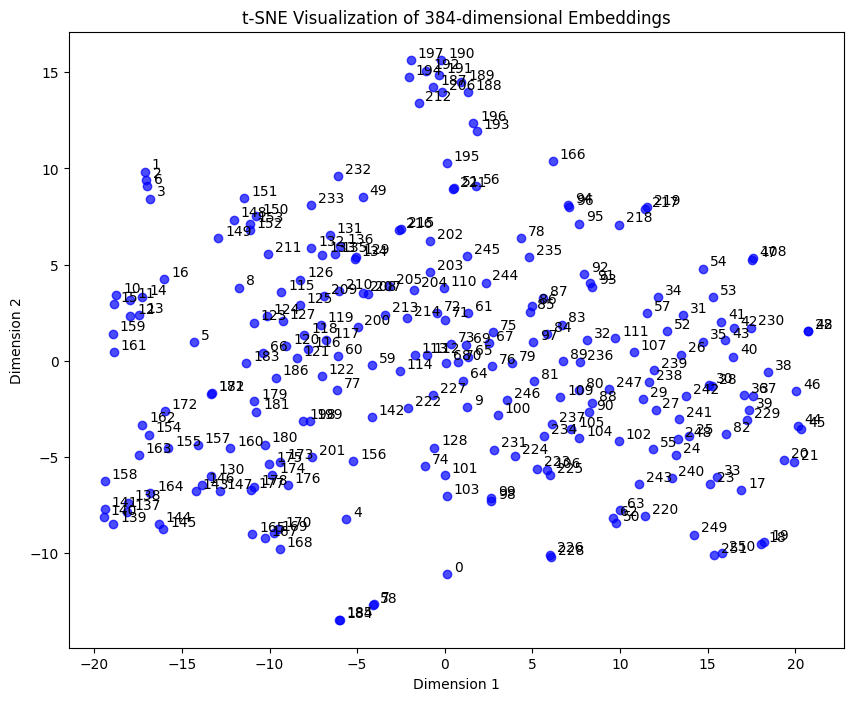

In [79]:
visualize_embeddings(embeddings_2d[:-1])

We'll also locate our **<span style="color: red">question</span>** is in this vector space.

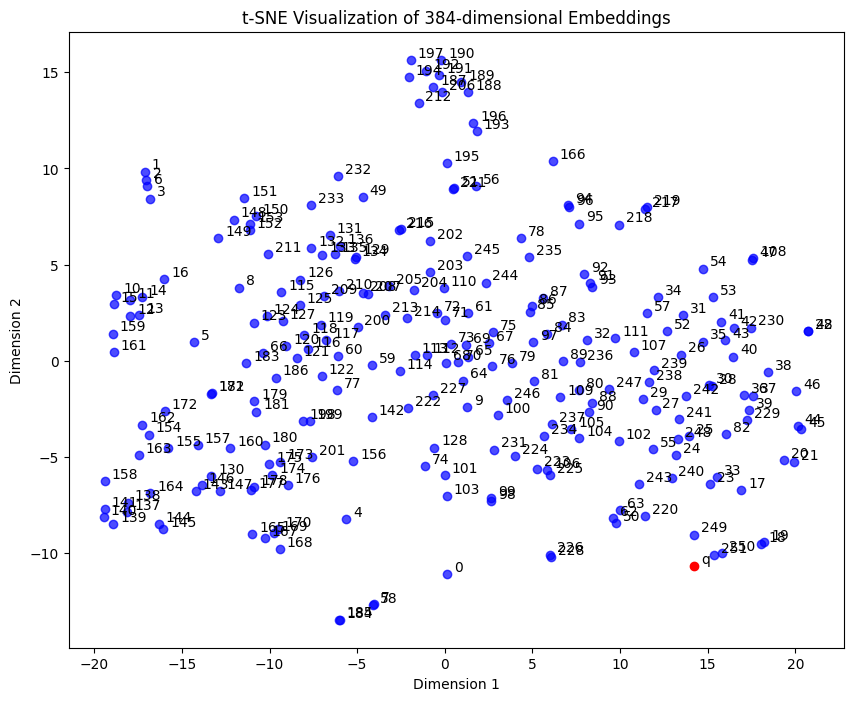

In [80]:
visualize_embeddings(embeddings_2d, True)

接下來，我們需要找到語義上更接近我們問題的文本片段。這些文本片段更有可能包含我們問題的答案。

有多種方法可以實現這一目標，我們將使用**歐幾里得距離**來衡量數據點的相似性/接近度。

為此，我們將使用**最近鄰居**(NearestNeighbors)算法，找到距離我們問題最接近的前`k`個數據點。在我們的示例中，我們將默認檢索前5個數據點。

In [81]:
nn_2d = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_2d.fit(embeddings_2d[:-1])

NearestNeighbors(metric='cosine')

In [82]:
neighbors = nn_2d.kneighbors(embeddings_2d[-1].reshape(1, -1), return_distance=False)
neighbors

array([[ 63, 220, 234, 251,  62]])

Let's now plot the closest points as **<span style="color: purple">purple</span>**.

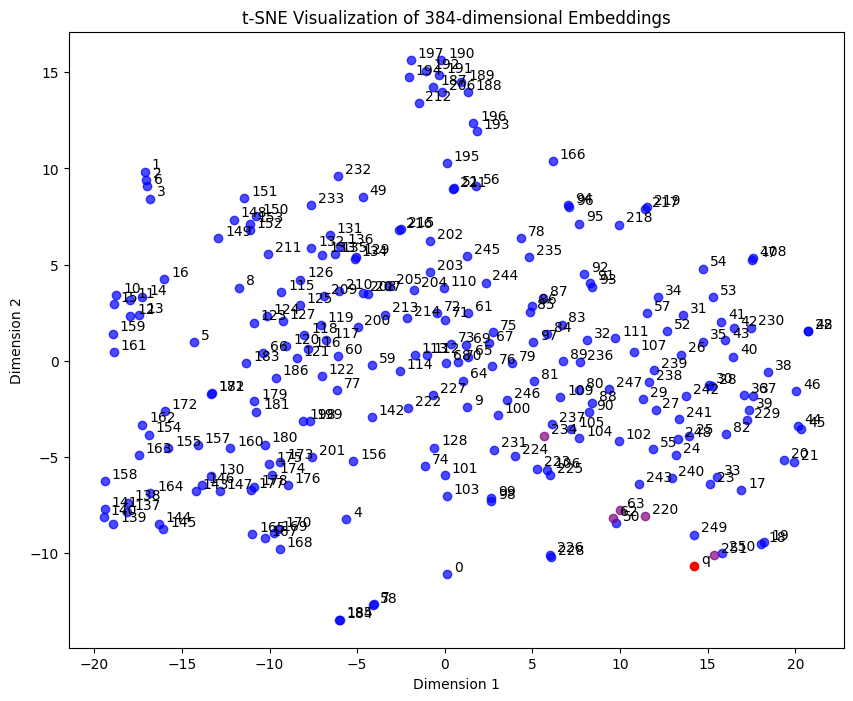

In [83]:
visualize_embeddings(embeddings_2d, True, neighbors)

## Semantic Search

由於t-SNE是一個非線性算法，在這個過程中我們會失去一些信息，所以我們將不使用2維向量，這些僅用於可視化目的。

我們將重複上述過程，但改為使用完整的384維向量。

再次套用我們的 NearestNeighbors，使用完整大小的嵌入。

In [101]:
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(embeddings)

NearestNeighbors(metric='cosine')

再次將我們的問題轉成嵌入

In [102]:
# question = 'How many people does this pie serve?'
question = '如何查詢成交明細?'
emb_question = emb_function([question])

最後取得我們的文本片段

In [103]:
neighbors = nn.kneighbors(emb_question, return_distance=False)
neighbors

array([[ 71, 214, 116, 149, 125]])

這樣一來，我們擁有最有可能回答我們問題的**前5**個文本片段。

In [105]:
topn_chunks = [chunks[i] for i in neighbors.tolist()[0]]

## Prompt Building

現在是建立我們的Prompt的時候。

請記住，我們需要將我們的上下文傳遞給Prompt。在這種情況下，我們將我們的上下文稱為*"Search results"* - 名稱並不重要；

我們將遍歷我們的頂部文本片段，並將它們附加到提示中。

最後，我們將向我們的模型提供指示，提出我們的問題，然後收到我們的答案。

In [131]:
def build_prompt(question):
    prompt = ""


    prompt += "[INST] <<SYS>>You are an AI assistant tasked with providing answers by summarizing related documents. You should follow these rules:\n"\
              "1. Summarize the content from the provided documents, using the following format:\n"\
              "Topic of the Document: Describe the topic of the document.\n"\
              "Step by Step Instruction: Provide user question-specific instructions or information from the document.\n"\
              "2. If no relevant information is found in the chat history, respond with \"I can't answer the question\".\n"\
              "By adhering to these rules, you will help users find accurate and valuable information.\n"\
              "<</SYS>>\n"

    prompt += 'Search results:\n'

    for c in topn_chunks:
        prompt += c + '\n\n'
    prompt += f"\n\n\nQuery: {question}\n\nAnswer: [/INST]"

    return prompt

In [132]:
prompt = build_prompt(question)
print(prompt)

[INST] <<SYS>>You are an AI assistant tasked with providing answers by summarizing related documents. You should follow these rules:
1. Summarize the content from the provided documents, using the following format:
文件標題: Describe the topic of the document.
按步指示: Provide user question-specific instructions or information from the document.
2. If no relevant information is found in the chat history, respond with "I can't answer the question".
By adhering to these rules, you will help users find accurate and valuable information.
<</SYS>>
Search results:
[Page no. 72] "70 1.8 詳細交易行情 【功能說明】 單一商品各欄位資料皆可在此選項中看到。 【操作說明】 在欲顯示詳細交易行情的切割版面中按下滑鼠右鍵，當切割版面為空白時，請點選「詳細交 易行情」；當切割版面中已呈現其他資訊時請點選「功能操作」 >「詳細交易行情」。該切 割版面即呈現詳細交易行情畫面，按下滑鼠右鍵選擇欲執行的功能。"

[Page no. 215] "213 8.11 原物料 【功能說明】 提供原物料相關的報價資訊。 【操作說明】 點選功能表列的「金融資訊」＞「原物料」 ，則該切割畫面即呈現原物料行情報價畫面 。 【畫面說明】 報價畫面提供：加入自設群組、設定欄位、欄位排序、輸出文字檔等功能，請參考功能篇 1-1報價資訊 。"

[Page no. 117] "115 2.1.2 委買委賣成交分析 【功能說明】 列出加權指數或櫃檯指數，每 5秒內增加的委買、委賣、成交之張數、筆數與平均張數資 料，並顯示出三者間之大小關係、大盤成交金額，

# watsonx.ai Inference

為了完成我們的程式，現在只需將提示發送給我們的模型，並根據我們提供的內容收到它的答案。

我們將配置我們的環境，使用我們的憑證，定義一個輔助函數，最後進行推理。

In [ ]:
# Config watsonx.ai environment

# load_dotenv()
# api_key = os.getenv("API_KEY", None)
# ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
# project_id = os.getenv("PROJECT_ID", None)

api_key = # <your-api-key>
ibm_cloud_url = "https://us-south.ml.cloud.ibm.com/"
project_id = "b191371c-cdd6-429d-be44-9c523a60975d"

if api_key is None or ibm_cloud_url is None or project_id is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    creds = {
        "url": ibm_cloud_url,
        "apikey": api_key
    }

In [134]:
def send_to_watsonxai(prompts,
                    model_name="meta-llama/llama-2-70b-chat",
                    decoding_method="greedy",
                    max_new_tokens=512,
                    min_new_tokens=0,
                    repetition_penalty=1.0
                    ):
    '''
   helper function for sending prompts and params to Watsonx.ai

    Args:
        prompts:list list of text prompts
        decoding:str Watsonx.ai parameter "sample" or "greedy"
        max_new_tok:int Watsonx.ai parameter for max new tokens/response returned
        temperature:float Watsonx.ai parameter for temperature (range 0>2)
        repetition_penalty:float Watsonx.ai parameter for repetition penalty (range 1.0 to 2.0)

    Returns: None
        prints response
    '''


    # Instantiate parameters for text generation
    model_params = {
        GenParams.DECODING_METHOD: decoding_method,
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_new_tokens,
        GenParams.RANDOM_SEED: 42,
        GenParams.TEMPERATURE: 0,
        GenParams.REPETITION_PENALTY: repetition_penalty,
    }


    # Instantiate a model proxy object to send your requests
    model = Model(
        model_id=model_name,
        params=model_params,
        credentials=creds,
        project_id=project_id)


    for prompt in prompts:
        print(model.generate_text(prompt))


Below, we have a few examples of questions to use with both PDF files available.

Feel free to choose any of them or come up with your own questions to test your new application!

In [135]:
# Example questions for the DQ2:
#   可以怎麼查詢成交狀況?
#   有辦法查詢原物料行情嗎?
#   我想查詢指數的委買跟委賣分析
#   DQ2 可以做到什麼功能?


question = "有辦法查詢原物料行情嗎?"
prompt = build_prompt(question)

send_to_watsonxai(prompts=[prompt], min_new_tokens=1)

  Yes, you can query the original material information. According to the search results, you can find the original material information in the "原物料" section of the "金融資訊" functionality. To access this information, follow these steps:

1. Click on the "功能表列" button.
2. Select "金融資訊" from the drop-down menu.
3. Click on "原物料" in the "金融資訊" section.
4. The "原物料" page will display a list of original materials, along with their current prices and other relevant information.

Alternatively, you can also use the "委買委賣成交分析" functionality to view the original material information. To do this, follow these steps:

1. Click on the "功能表列" button.
2. Select "股市" from the drop-down menu.
3. Click on "台灣股市" in the "股市" section.
4. Click on "委買委賣成交分析" in the "台灣股市" section.
5. The "委買委賣成交分析" page will display a list of original materials, along with their current prices and other relevant information.

I hope this helps! Let me know if you have any further questions.
